In [67]:
import os

import numpy as np

from photutils.utils import ImageDepth
from photutils.segmentation import SourceFinder

from astropy.io import fits

import matplotlib.pyplot as plt

In [68]:
def measure():

    home = os.getcwd()
    data = f'{home}/data/'
    
    f275w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F275W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'

    f275w_header = fits.getheader(f275w_file)

    inverse_sensitivity = f275w_header['PHOTFLAM']

    f275w = fits.getdata(f275w_file)[3500:5000, 3500:5500]

    f275w = f275w * inverse_sensitivity

    f275w = f275w * 2709.7**2 / (3e8 * 1e10)

    nan_mask = np.isnan(f275w)

    finder = SourceFinder(npixels=9, progress_bar=False)

    mask = finder(np.where(nan_mask, 0, f275w), abs(np.nanmedian(f275w))).make_source_mask()

    depth = ImageDepth(4., nsigma=5., mask_pad=4., napers=100, niters=1000, seed=123, zeropoint=-48.6, progress_bar=False)

    limits = depth(f275w, (nan_mask | mask))

    print(limits)

(2.042339460023522e-31, 28.12468017893024)


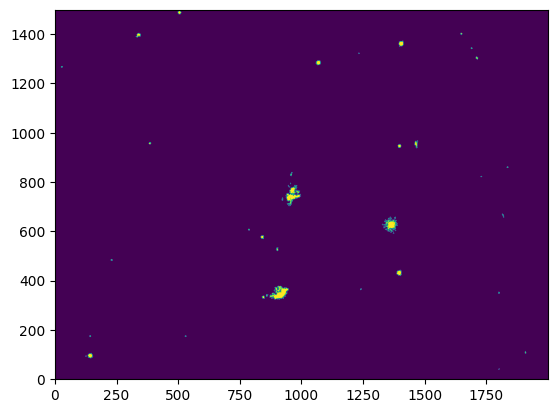

In [69]:
measure()